# ДЗ

В этой домашней работе вам предстоит решить задачу ассоциации изображений методами metric learning. Необходимо обучить нейронную сеть для поиска похожих автомобилей из датасета cars196. Учтите, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта (не используем метод прямой классификации). Пример формирования предсказаний можно найти в ноутбуке: [metric_learning.ipynb](metric_learning.ipynb) блок Faiss

В процессе решения нужно решить пункты:
1. Реализовать метрики: Precision@k, Recall@k, mAP (1 балл)
2. Добавить train аугментации (1 балл)
3. Обучить модель (2 балла)
   * При обучении использовать backbone отличный от того, что использовался на семинаре (не ResNet50)
   * Добавить triplet-loss (помните о грамотном формировании триплетов)
   * Рассчитать метрики из п.1
4. Показать с помощью GradCAM, где ошибается модель (1 балл)

### 1. Реализация метрик Precision@k, Recall@k, mAP

In [1]:
import math
import numpy as np

from typing import Optional, Tuple, List, Dict

Для реализации метри составим матрицу соседей.

- 1 - метка соседа совпадает с меткой запроса;
- 0 - не совпадает;
    Совместимо с Faiss-выходом (I) из metric_learning.ipynb.

In [2]:
def build_neighb_matrix(
    faiss_indices: np.ndarray, # список соседей в виде индексов
    query_labels: np.ndarray, # метка запроса
    candidate_labels: np.ndarray # метки кандидатов
):
    return (candidate_labels[faiss_indices] == query_labels[:, None]).astype(np.int32)

Precision@k = средняя доля релевантных среди первых k соседей

In [3]:
def precision_at_k(neighbour, k):
    k = min(k, neighbour.shape[1])
    if k <= 0:
        return 0.0
    per_query = neighbour[:, :k].sum(axis=1) / float(k)
    return float(per_query.mean())

Recall@k = доля запросов, у которых в топ-k есть хотя бы один релевантный сосед.

In [4]:
def recall_at_k_hit(neighbour, k):
    k = min(k, neighbour.shape[1])
    if k <= 0:
        return 0.0
    hit = (neighbour[:, :k].sum(axis=1) > 0).astype(np.float32)
    return float(hit.mean())

AP: среднее Precision@i по позициям, где rel[i]==1

In [5]:
def average_precision_from_neighbour(neigb_row, top_k):
    if top_k is not None:
        rel = neigb_row[:top_k].astype(np.int32, copy=False)
    else:
        rel = neigb_row.astype(np.int32, copy=False)

    if rel.sum() == 0: #Если релевантных нет AP=0.
        return 0.0

    cumsum = np.cumsum(rel)               
    positions = np.arange(1, len(rel) + 1)
    precision_at_i = cumsum / positions
    ap = (precision_at_i * rel).sum() / rel.sum()
    return float(ap)

mAP — среднее AP по всем запросам

In [6]:
def mean_average_precision(neighbour, top_k):
    ap_list = [average_precision_from_neighbour(neighbour[i], top_k=top_k)
               for i in range(neighbour.shape[0])]
    return float(np.mean(ap_list)) if len(ap_list) else 0.0

### Добавим train-аугментации

In [7]:
import os
import random
import cv2

from scipy.io import loadmat

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

Загрузка аннотаций Cars196 и подготовка словарей

In [8]:
DEVKIT_DIR = 'data/devkit'
TRAIN_DIR = 'data/archive/cars_train/'

ann = loadmat(os.path.join(DEVKIT_DIR, 'cars_train_annos.mat'))
meta = loadmat(os.path.join(DEVKIT_DIR, 'cars_meta.mat'))

class_names = [c[0] for c in meta['class_names'][0]]
id_to_car = {i: name for i, name in enumerate(class_names)} 

# нужен filename и класс
fname_to_class = {}
for rec in ann['annotations'][0]:
    fname = str(rec['fname'][0]) #rec['fname'] -> массив строк длины 1;
    cls = int(rec['class'][0][0]) - 1  #  1:196 -> 0:195
    fname_to_class[fname] = cls

items = [(fn, cls) for fn, cls in fname_to_class.items()]

random.shuffle(items)
split = int(0.8 * len(items))
train_items = items[:split]
val_items   = items[split:]
len(train_items), len(val_items), len(class_names)

(6515, 1629, 196)

In [9]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_transforms = T.Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(224, scale=(0.6, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

Реализуем CropClassifDataset и формируем DataSet и DataLoader аналогично metric_learning.ipynb

In [10]:
class CropClassifDataset(Dataset):
    def __init__(self, root_dir, items, transforms=None):
        self.root_dir = root_dir
        self.items = items
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        fname, label = self.items[idx]
        img_path = os.path.join(self.root_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            img = self.transforms(img)

        return {"image": img, "label": label}

In [11]:
img_path = os.path.join(TRAIN_DIR, fname)
print(img_path)

data/archive/cars_train/08144.jpg


In [12]:
train_ds = CropClassifDataset(TRAIN_DIR, train_items, transforms=train_transforms)
val_ds   = CropClassifDataset(TRAIN_DIR, val_items,   transforms=val_transforms)

In [13]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=False, drop_last = True)
valid_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=False)

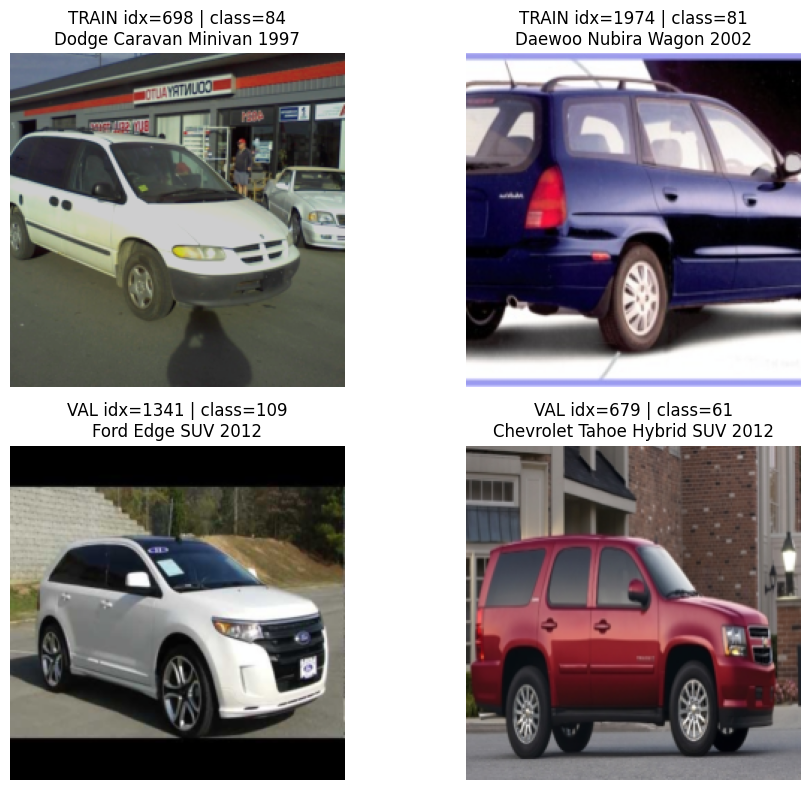

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean).reshape(1,1,3)
    std  = np.array(std).reshape(1,1,3)
    img = img * std + mean
    img = np.clip(img, 0.0, 1.0)
    return img

rng = np.random.default_rng()
train_idxs = rng.choice(len(train_ds), size=2, replace=False)
val_idxs   = rng.choice(len(val_ds),   size=2, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# из train_ds
for i, idx in enumerate(train_idxs):
    sample = train_ds[idx]
    img = denormalize(sample["image"])
    label = int(sample["label"])
    title = f"TRAIN idx={idx} | class={label}"
    if 'id_to_car' in globals():
        title += f"\n{id_to_car[label]}"
    axes[0, i].imshow(img)
    axes[0, i].set_title(title)
    axes[0, i].axis('off')

# из val_ds
for i, idx in enumerate(val_idxs):
    sample = val_ds[idx]
    img = denormalize(sample["image"])
    label = int(sample["label"])
    title = f"VAL idx={idx} | class={label}"
    if 'id_to_car' in globals():
        title += f"\n{id_to_car[label]}"
    axes[1, i].imshow(img)
    axes[1, i].set_title(title)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Обучение модели

В качестве backbone выбираем MobileNetV2 из torchvision, почему именно его:
- лёгкий CNN-backbone из стандартной библиотеки, без внешних зависимостей;
- обучен на ImageNet и ожидает ровно те же mean=IMAGENET_MEAN, std=IMAGENET_STD, которые мы уже используем в трансформациях;
- размер входа 224×224 — совпадает с принятым в семинаре;
- последний канал признаков — 1280, чтобы поверх поставить нашу эмбеддинг-голову;

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from pytorch_metric_learning import losses, miners, distances


MobileNetV2 с ImageNet-весами.

В torchvision forward: features -> avgpool -> flatten -> classifier.

Мы заменим classifier на Identity и будем забирать признак размера 1280.

In [16]:
def create_mobilenetv2_backbone(pretrained: bool = True):
    weights = MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None
    m = mobilenet_v2(weights=weights)
    m.classifier = nn.Identity()
    feat_dim = 1280
    return m, feat_dim

Аналогично metric_learning.ipynb

In [17]:
class CarEmbedder(pl.LightningModule):
    def __init__(
        self,
        num_classes: int,
        emb_size: int = 512,
        lr: float = 1e-3,
        use_triplet: bool = True,
        triplet_margin: float = 0.2
    ):
        super().__init__()
        self.save_hyperparameters()

        self.backbone, feat_dim = create_mobilenetv2_backbone(pretrained=True)

        self.embed_head = nn.Linear(feat_dim, emb_size)

        self.arcface = losses.ArcFaceLoss(
            num_classes=num_classes,
            embedding_size=emb_size,
            margin=28.6,
            scale=64
        )

        self.use_triplet = use_triplet
        if self.use_triplet:
            self.distance = distances.CosineSimilarity()
            self.miner = miners.TripletMarginMiner(
                margin=triplet_margin,
                type_of_triplets="semihard",
                distance=self.distance
            )
            self.triplet = losses.TripletMarginLoss(
                margin=triplet_margin,
                distance=self.distance
            )

        self.lr = lr

    def forward(self, x):
        feats = self.backbone(x) # (B, 1280)
        emb = self.embed_head(feats)# (B, emb_size)
        return emb

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        emb = self(x)

        loss = self.arcface(emb, y)

        if self.use_triplet:
            hard_triplets = self.miner(emb, y)
            triplet_loss = self.triplet(emb, y, hard_triplets)
            loss = loss + triplet_loss
            self.log("train_triplet", triplet_loss, prog_bar=False, on_step=True, on_epoch=True)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        emb = self(x)
        val_loss = self.arcface(emb, y)
        if self.use_triplet:
            hard_triplets = self.miner(emb, y)
            val_loss = val_loss + self.triplet(emb, y, hard_triplets)

        self.log("validation_loss", val_loss, prog_bar=True, on_epoch=True)
        return val_loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return opt

Инициализация модели и callback

In [18]:
num_classes = len(class_names)

pl.seed_everything(42)

model = CarEmbedder(
    num_classes=num_classes,
    emb_size=512,
    lr=1e-3,
    use_triplet=True,
    triplet_margin=0.2
)

checkpoint_cb = ModelCheckpoint(
    monitor="validation_loss",
    mode="min",
    save_top_k=1,
    filename="mobilenetv2-emb-{epoch:02d}-{validation_loss:.4f}"
)

earlystop_cb = EarlyStopping(monitor="validation_loss", mode="min", patience=3)
lrmon_cb = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=25,
    accelerator="mps",
    devices=1,
    precision="32-true",
    callbacks=[checkpoint_cb, earlystop_cb, lrmon_cb],
    log_every_n_steps=20
)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, train_loader, valid_loader)


  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | backbone   | MobileNetV2        | 2.2 M  | train
1 | embed_head | Linear             | 655 K  | train
2 | arcface    | ArcFaceLoss        | 100 K  | train
3 | distance   | CosineSimilarity   | 0      | train
4 | miner      | TripletMarginMiner | 0      | train
5 | triplet    | TripletMarginLoss  | 0      | train
----------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.920    Total estimated model params size (MB)
220       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruaord3/Desktop/Hometask/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/ruaord3/Desktop/Hometask/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Извлечение эмбеддингов

In [20]:
@torch.no_grad()
def get_embeds(pl_module, loader):
    pl_module.eval()
    all_emb = []
    all_y = []
    for batch in loader:
        x = batch["image"].to(pl_module.device)
        y = batch["label"].to(pl_module.device)
        emb = pl_module(x)                    
        all_emb.append(emb.detach().cpu())
        all_y.append(y.detach().cpu())
    embs = torch.cat(all_emb, dim=0).numpy().astype("float32")
    labels = torch.cat(all_y, dim=0).numpy().astype("int64")
    return embs, labels

train_emb, train_labels = get_embeds(model, train_loader)
val_emb,   val_labels   = get_embeds(model, valid_loader)
train_emb.shape, val_emb.shape

((6496, 512), (1629, 512))

Объединими метрики из п.1 в одну функцию

In [21]:
def evaluate_from_faiss_indices(
    faiss_indices,
    query_labels,
    gallery_labels,
    k_list,
    map_or_not: bool = True
):
    rel = build_neighb_matrix(faiss_indices, query_labels, gallery_labels)

    results = {}
    for k in k_list:
        results[f"Precision@{k}"] = precision_at_k(rel, k)
        results[f"Recall@{k}"]    = recall_at_k_hit(rel, k)

    if map_or_not:
        Kmax = faiss_indices.shape[1]
        results["mAP"]           = mean_average_precision(rel, top_k=None)
        results[f"mAP@{Kmax}"]   = mean_average_precision(rel, top_k=Kmax)

    return results

Использовать библитеку FAISS по примеру семинара не удалась, при импорте библитеки ядро python аварийно завершает работу, применим NearestNeighbors из sklearn.neighbors

In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

metric = "euclidean"

k = 8
emb_size = train_emb.shape[1]

X_train = train_emb.astype(np.float32, copy=False)
X_query = val_emb.astype(np.float32, copy=False)

nn = NearestNeighbors(
    n_neighbors=k,
    algorithm="brute",
    metric=metric,
    n_jobs=-1          # задействуем все CPU
)
nn.fit(X_train)

D, I = nn.kneighbors(X_query, n_neighbors=k, return_distance=True)

results = evaluate_from_faiss_indices(I, val_labels, train_labels, k_list=[1, 2, 4, 8])
results

{'Precision@1': 0.7004297114794352,
 'Recall@1': 0.7004297375679016,
 'Precision@2': 0.6850828729281768,
 'Recall@2': 0.7507673501968384,
 'Precision@4': 0.6605279312461633,
 'Recall@4': 0.7882136106491089,
 'Precision@8': 0.6247697974217311,
 'Recall@8': 0.8268876671791077,
 'mAP': 0.7214485362387231,
 'mAP@8': 0.7214485362387231}

### Покажем с помощью GradCAM, где ошибается модель

Немного модифицируем SimilarityToVectorTarget из семинара:

In [23]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

class SimilarityToVectorTarget:
    def __init__(self, concept_vector: np.ndarray, device: torch.device):
        v = torch.as_tensor(concept_vector, dtype=torch.float32, device=device)
        self.v = v / (v.norm(p=2) + 1e-8)

    def __call__(self, model_output: torch.Tensor) -> torch.Tensor:
        if model_output.ndim == 1:
            emb = model_output / (model_output.norm(p=2) + 1e-8)  # (emb_size,)
            return torch.dot(emb, self.v)         
        else:
            emb = model_output / (model_output.norm(dim=1, keepdim=True) + 1e-8)  # (B, emb)
            return (emb @ self.v).sum()                                    

Выберем изображения, где модель ошибается

Ошибок: 488 / 1629


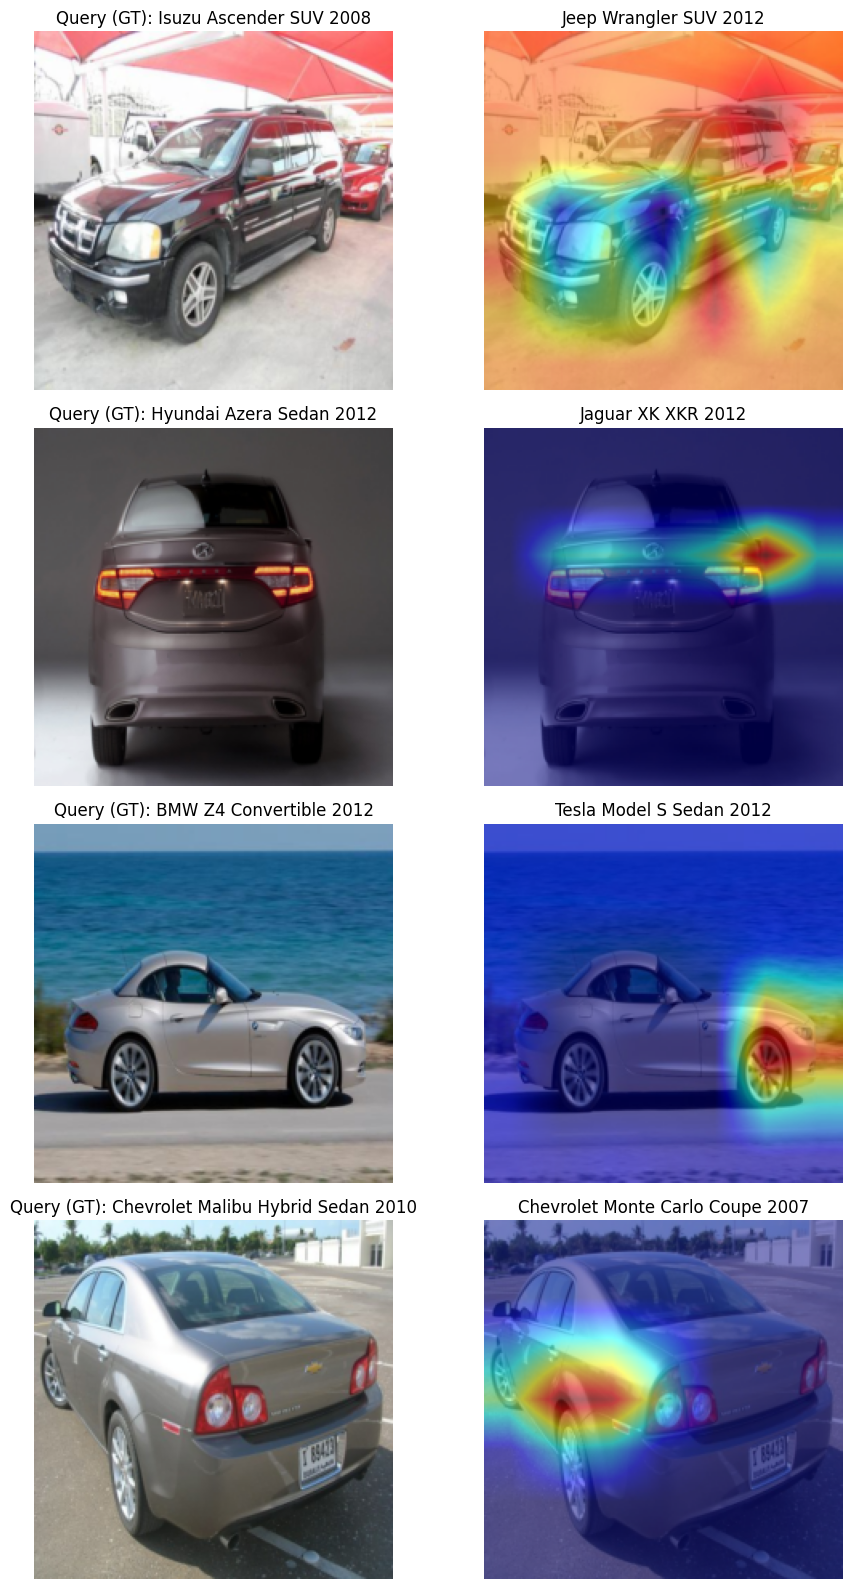

In [ ]:
top1_labels = train_labels[I[:, 0]]
wrong_idx = np.where(top1_labels != val_labels)[0]
print(f"Ошибок: {len(wrong_idx)} / {len(val_labels)}")

# target layer для MobileNetV2
target_layers = [model.backbone.features[-1][0]]  # Conv2d
cam = GradCAM(model=model, target_layers=target_layers)
model.eval()

N_SHOW = min(10, len(wrong_idx))
sel = wrong_idx[:N_SHOW]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(N_SHOW, 2, figsize=(10, 4*N_SHOW))
if N_SHOW == 1:
    axes = np.array([axes])

for row, q in enumerate(sel):
    sample = val_ds[q]
    img_t = sample["image"].unsqueeze(0).to(model.device)   # (1,C,H,W)
    img_show = denormalize(sample["image"])
    gt = int(val_labels[q])
    gt_name = id_to_car[gt] if 'id_to_car' in globals() else str(gt)

    wrong_neighbor_idx = I[q, 0]
    concept_vec = train_emb[wrong_neighbor_idx]
    pred = int(train_labels[wrong_neighbor_idx])
    pred_name = id_to_car[pred] if 'id_to_car' in globals() else str(pred)

    targets = [SimilarityToVectorTarget(concept_vec, device=model.device)]
    grayscale_cam = cam(input_tensor=img_t, targets=targets)
    grayscale = grayscale_cam[0]
    overlay = show_cam_on_image(img_show, grayscale, use_rgb=True)

    axes[row, 0].imshow(img_show)
    axes[row, 0].set_title(f"Query (GT): {gt_name}")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(overlay)
    axes[row, 1].set_title(f"{pred_name}")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()